# Adding interactive controls

We will be adding interactive controls to our graphs using the ```ipywidgets``` [library](https://ipywidgets.readthedocs.io/en/stable/index.html). This is basically a Graphical User Interface ([GUI](https://en.wikipedia.org/wiki/Graphical_user_interface)) library that runs in a notebook. Its control elements (so-called [widgets](https://en.wikipedia.org/wiki/Graphical_widget)) are actually an interface to [JavaScript](https://en.wikipedia.org/wiki/JavaScript) code that runs in your browser (in a stardard GUI library meant for desktop applications, they would be written in some low-level language and interface with the [window manager](https://en.wikipedia.org/wiki/Window_manager) on your computer). An in-depth treatment of GUIs is beyond the scope of this tutorial. However, I will strive to highlight concepts of general applicability and to use a clean syntax that highlights where the various elements fit in and may be easier to port to other GUI toolkits. If you are interested in learning more about (desktop-based) GUIs in Python, I strongly recommend the [appJar](http://appjar.info/) library - it is an excellent learning library and a great quick prototyping tool as well.

The ```ipywidgets``` library is an integral part of the Jupyter framework and should therefore already be installed on any machine you are running this notebook on. If for some reason it isn't, follow these [instructions](https://ipywidgets.readthedocs.io/en/stable/user_install.html) to install it.

In [2]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

## Updating your data

It is a good idea to provide some data on the disk for your dashboard to start on - after all, the PHE website might be offline when someone accesses your dashboard; also, accessing the PHE website directly would make startup time longer. However, you can provide a button that the user can click to poll the API and refresh the data.

The ```ipywidgets``` library provides a ```Button``` class that implements a [clickable button](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html?highlight=button#Button). The way this is linked to your code is through a [callback function](https://en.wikipedia.org/wiki/Callback_(computer_programming)). This is a function that is passed as a parameter to the ```on_click``` method of the ```Button``` object, that in turn calls it when it is clicked. The callback function is passed the ```Button``` object itself as a parameter (which is useful if more than one button, for instance, shares the same callback). We can safely ignore that here.

The call to ```display``` below actually draws the button on the notebook.

In [11]:
# our API access function. This will be called by the button when it is clicked
def access_api(button):
    # Ignore the button parameter
    #
    # put code for polling the API here
    #
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again.
    apibutton.icon="check"
    apibutton.disabled=True

# see the doc for the parameters    
apibutton=wdg.Button(
    description='Refresh data',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to download current Public Health England data',
    icon='download' # (FontAwesome names without the `fa-` prefix)
)

# register the callback function with the button
apibutton.on_click(access_api)

# this is an iPython function that generalises print for Jupyter Notebooks; we use it to 
# display the widgets
display(apibutton)

Button(description='Refresh data', icon='download', style=ButtonStyle(), tooltip='Click to download current Pu…

## Single-control graphs

Adding an interactive control to a graph is not much more complicated. The control can be any of the many [widgets](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#) provided by ```iPywidgets```. Here we have chosen ```Select``` that allows us to select a year (see the [doc](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#Select)). We use the year to filter the DataFrame, and display the data for that year aggregated by month as a multiple stacked bar chart 

Again, ```Select``` makes use of a callback, that gets passed the option that have been selected. Each time the selection is changed, the callback function is called again. The way the callback is registered with the widget is slightly different: the callback (here ```lineage_graph```) must take a single parameter (the selected year, called ```graphyear```). We then pass the callback to ```interactive_output```, together with a dictionary that specifies which widget (```year```) must provide a value for the callback parameter (```graphyear```). Basically, the ```iPywidget``` framework  calls ```lineage_graph``` with the value retrieved from the widget after each user interaction.  The value of ```interactive_output``` is an ```Output``` widget (see the [doc](https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html)), that can be assigned to a variable and passed to ```display``` together with the ```year``` widget itself. Any printout, graph or other output of the callback ```lineage_graph``` is captured and displayed through that ```Output``` widget, that renders it in the browser.

In [5]:
# in the dashboard, this will be the dataframe that's computed directly from the json files,
# or from the current data downloaded from the API
lineagedf=pd.read_pickle("lineagedf.pkl")

Select(description='Year', index=3, options=(2021, 2022, 2023, 2024), rows=1, value=2024)

Output()

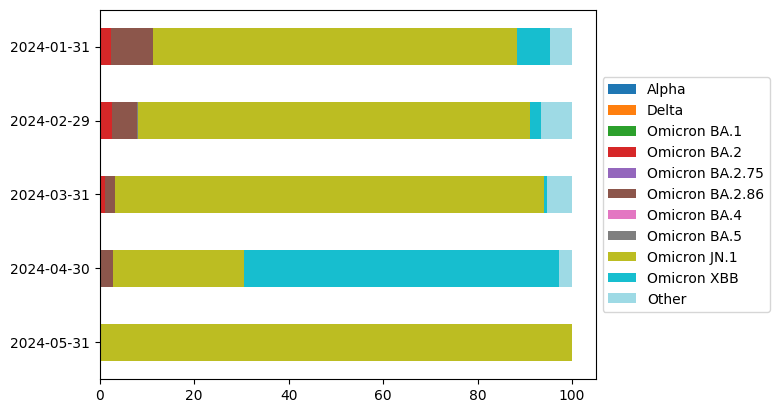

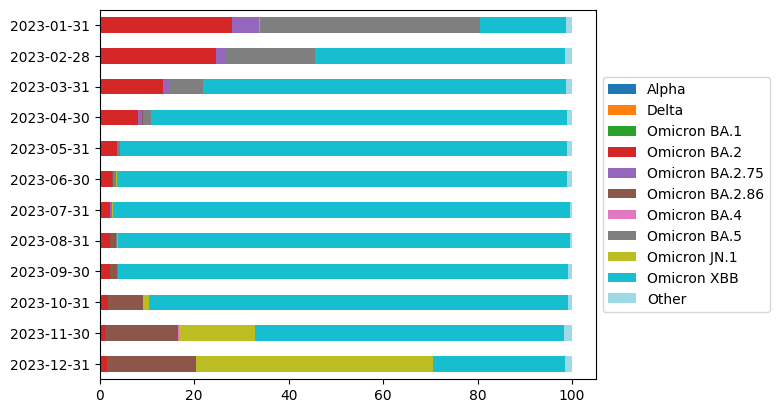

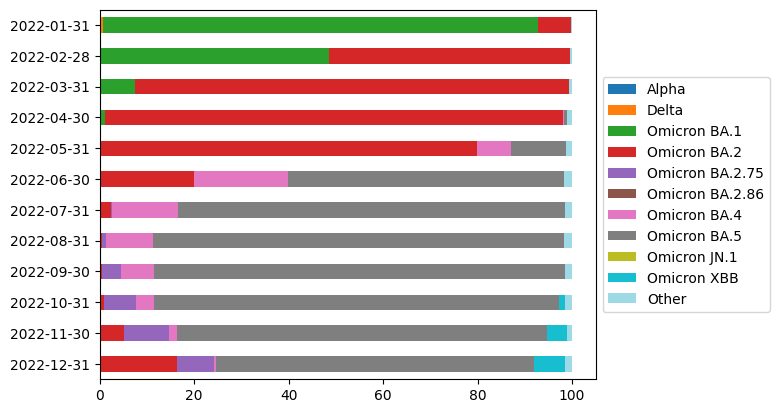

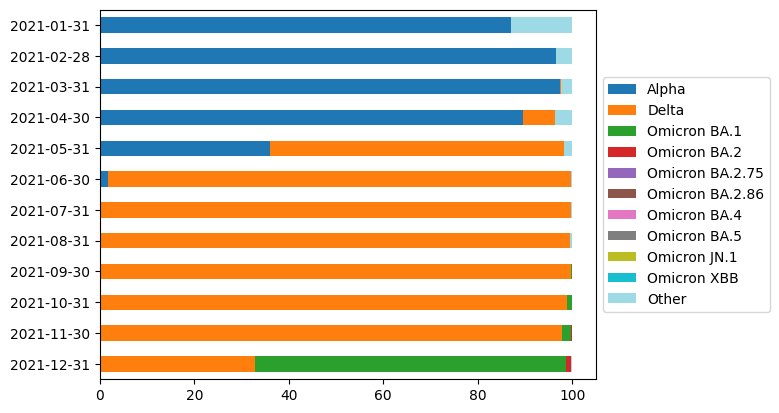

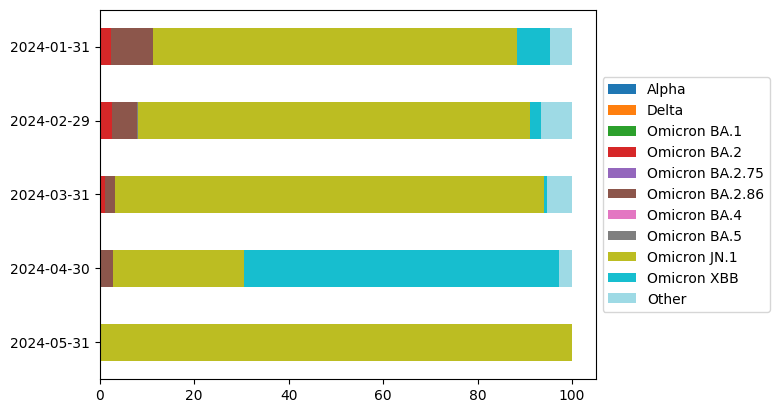

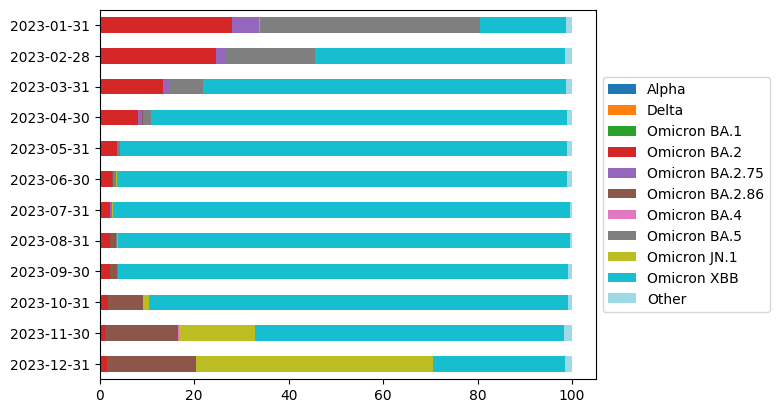

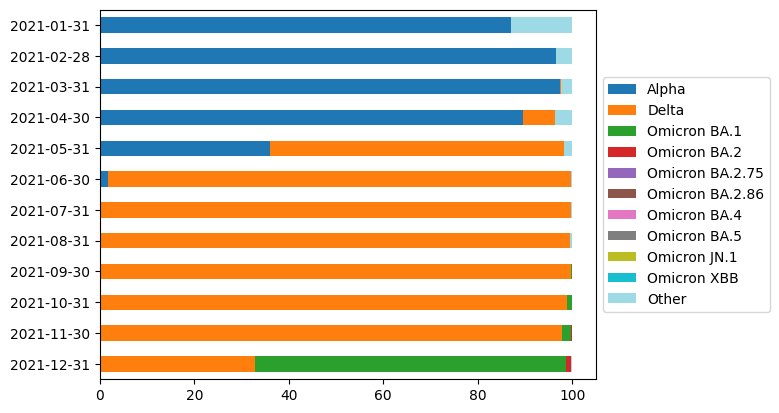

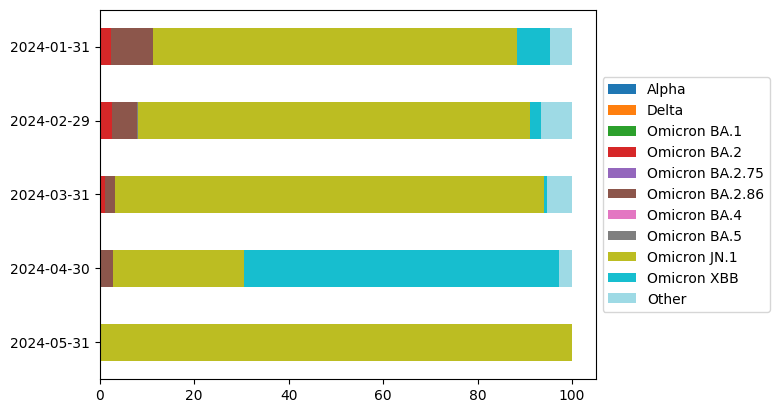

In [12]:
year=wdg.Select(
    # options available: unique years in the dataframe
    options=lineagedf.index.year.unique(), # options available
    value=lineagedf.index.year[-1], # initial value: most recent year
    rows=1, # rows of the selection box
    description='Year',
    disabled=False
)

def lineage_graph(graphyear):
    # our callback function.
    yeardf=lineagedf[lineagedf.index.year==graphyear]
    # average the rows by month
    monthly= yeardf.groupby(pd.Grouper(freq='1M')).mean() 
    totals=monthly.sum(axis=1) # over the rows
    # make sure it's all normalised to 100
    monthly=monthly.div(totals, axis=0)*100
    # older dates on top of the graph
    monthly = monthly[::-1]
    ax=monthly.plot(kind='barh', stacked=True,cmap='tab20')
    ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    ax.set_yticklabels(monthly.index.strftime('%Y-%m-%d'))
    
# keep calling age_graph(graphcolumns=value_of_agecols); capture output in widget output    
output=wdg.interactive_output(lineage_graph, {'graphyear': year})

display(year, output)

## Multiple-control graphs

In the time series graph, we may want to add a couple of controls - one for selecting the stats to display, and the other to choose between an linear and logarithmic scale. This second choice we can implement with a ```RadioButtons``` widget ([documentation](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#RadioButtons)). This widget returns a Boolean value (```True``` or ```False```) to the callback function. The callback (in our case ```timeseries_graph```) must then accept two parameteres,  a tuple of stats coming from the ```SelectMultiple``` widget and the Boolean value from the ```RadioButtons```. Again, the ```interactive_output``` function associates the widgets with the callback and captures the output in an ```Output``` widget.

The new element in this example is the [container widget](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#Container/Layout-widgets) ```HBox```. Container widgets are another feature shared by most GUI toolkits; they are used to group  and arrange other widgets on the interface.

In [7]:
# in the dashboard, this should be computed from the json files
timeseriesdf=pd.read_pickle("timeseriesdf.pkl")

In [14]:
series=wdg.SelectMultiple(
    options=['cases', 'admissions', 'deaths'],
    value=['cases', 'admissions', 'deaths'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
#   value='pineapple', # Defaults to 'pineapple'
#   layout={'width': 'max-content'}, # If the items' names are long
    description='Scale:',
    disabled=False
)

# try replacing HBox with a VBox
controls=wdg.HBox([series, scale])

def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        timeseriesdf[list(gcols)].plot(logy=logscale)
        plt.show() # important - graphs won't update if this is missing 
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

# keep calling timeseries_graph(gcols=value_of_series, gscale=value_of_scale); 
# capture output in widget graph   
graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)

Output()

Note how the ```HBox``` widget allows us to display the two control widgets side by side. Containers can be nested, so for instance an ```HBox``` can contain a ```VBox```. Since ```graph``` is also a widget (in fact, an ```Output``` widget), this allows crafting advanced layouts. The detailed [layout of widgets](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html) is an intricate topic that goes beyond the scope of this tutorial. 

## Your turn

Load the *pickle* file with the ```DataFrame``` you saved at the end of the previous notebook and add interactive controls to your graph. You can pick one of more widgets from this [list](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html), including any containers if required. I recommend that, at least initially, you stick with what is simple and just works.

**(C) 2020,2024 Fabrizio Smeraldi** ([f.smeraldi@qmul.ac.uk](mailto:f.smeraldi@qmul.ac.uk) - [web](http://www.eecs.qmul.ac.uk/~fabri/)). This notebook is released under the [GNU GPLv3.0 or later](https://www.gnu.org/licenses/).